In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import numpy as np

# Load the data
with open('data/shell_comparison_RAL_with_prm3.json') as f:
    data = json.load(f)

# Flatten the data and load it into a pandas DataFrame
df = pd.json_normalize(data)

# Rename the columns to remove the dots
df.columns = df.columns.str.split('.').str[-1]

# df = df[df['repId'] < 5]

df['time'] /= 1000
df = df[df['time'] < 200] # It seems we accidentally let some of the planners go past the 200s time limit, so we cut those off as invalid.

# Calculate n_visited/n_total
df['visit_ratio'] = df['n_visited'] / df['n_total']

# Get the maximum visit_ratio for each scene
max_visit_ratio = df.groupby('scene')['visit_ratio'].transform('max')

# Create a new column to indicate if the visit_ratio is below 0.95 times the maximum for that scene
df['low_visit_ratio'] = df['visit_ratio'] < 0.95 * max_visit_ratio

df['length_per_visited'] = df['total_path_length'] / df['n_visited']

agg = df.groupby(['name','prm_build_time','samples_per_goal','scene','approach_max_t','shell_type','low_visit_ratio'], dropna=False).mean().reset_index()
agg['planner'] = np.where(agg['shell_type'].isnull(), agg['name'], agg['name'] + ' (' + agg['shell_type'] + ')')

# Group by 'scene' and find the 'n_total' for each group
n_total_per_scene = agg.groupby('scene')['n_total'].first().reset_index()

# Modify the binning to start from 0
bins = pd.IntervalIndex.from_tuples([(0, 50), (50, 100), (100, 300), (300, 600)])
n_total_per_scene['bin'] = pd.cut(n_total_per_scene['n_total'], bins)

# Show the DataFrame
n_total_per_scene.sort_values('bin')

# Merge the 'n_total_per_scene' DataFrame into 'agg'
agg = pd.merge(agg, n_total_per_scene[['scene', 'bin']], on='scene')

# Show the DataFrame
agg

,name,prm_build_time,samples_per_goal,scene,approach_max_t,shell_type,low_visit_ratio,result,n_total,repId,n_visited,time,total_experiment_runtime,total_path_length,visit_ratio,length_per_visited,planner,bin
0,shell_based,NaN,NaN,appletree,0.10,cgal_convex_hull,True,NaN,165.0,4.5,105.3,17.9628,19422.1,292.822183,0.638182,2.779100,shell_based (cgal_convex_hull),"(100, 300]"
1,shell_based,NaN,NaN,appletree,0.10,minimum_enclosing_sphere,True,NaN,165.0,4.5,112.8,18.9002,20380.1,347.973504,0.683636,3.081603,shell_based (minimum_enclosing_sphere),"(100, 300]"
2,shell_based,NaN,NaN,appletree,0.25,cgal_convex_hull,True,NaN,165.0,4.5,115.7,27.9091,29449.4,356.398954,0.701212,3.078218,shell_based (cgal_convex_hull),"(100, 300]"
3,shell_based,NaN,NaN,appletree,0.25,minimum_enclosing_sphere,True,NaN,165.0,4.5,126.1,30.7799,32286.6,422.970160,0.764242,3.352977,shell_based (minimum_enclosing_sphere),"(100, 300]"
4,shell_based,NaN,NaN,appletree,0.50,cgal_convex_hull,True,NaN,165.0,4.5,122.9,38.4727,40074.1,399.753222,0.744848,3.251955,shell_based (cgal_convex_hull),"(100, 300]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
805,tsp_over_prm*,5.0,1.0,plumtree1,NaN,NaN,True,NaN,600.0,4.5,359.4,47.6823,47961.3,1437.285903,0.599000,4.000616,tsp_over_prm*,"(300, 600]"
806,tsp_over_prm*,5.0,2.0,plumtree1,NaN,NaN,True,NaN,600.0,4.5,474.9,141.3808,141647.3,1657.844472,0.791500,3.489879,tsp_over_prm*,"(300, 600]"
807,tsp_over_prm*,10.0,1.0,plumtree1,NaN,NaN,True,NaN,600.0,4.5,386.1,63.4798,63754.9,1516.737187,0.643500,3.933736,tsp_over_prm*,"(300, 600]"
808,tsp_over_prm*,10.0,2.0,plumtree1,NaN,NaN,True,NaN,600.0,5.2,495.8,181.5700,181843.4,1694.846988,0.826333,3.418218,tsp_over_prm*,"(300, 600]"


In [2]:
def get_planner_name(planner, shell_type):
    """
    Given a planner and shell type, return a user-friendly planner name.
    
    Args:
        planner (str): The name of the planner.
        shell_type (str): The type of shell.
        
    Returns:
        str: A user-friendly planner name.
    """
    if planner == 'shell_based':
        if shell_type == 'minimum_enclosing_sphere':
            return 'Sphere Shell'
        elif shell_type == 'cgal_convex_hull':
            return 'Convex Hull Shell'
    elif planner.startswith('tsp_over_prm'):
        return 'TSPoPRM*'
    return None


def plot_scene_data(ax, scene_runs, color_map, low_color_map, handles, labels):
    """
    Plot the scene data on the given axis.
    
    Args:
        ax (matplotlib.axis): The axis to plot the data on.
        scene_runs (DataFrame): The data for the scene.
        color_map (dict): Mapping of planner names to colors.
        low_color_map (dict): Mapping of planner names to low ratio colors.
        handles (list): List to store handles for the legend.
        labels (list): List to store labels for the legend.
    """
    # Iterate through the groups of data defined by planner and shell type
    for ((planner, st), runs) in scene_runs.groupby(['name', 'shell_type'], dropna=False):
        
        # Get the user-friendly planner name
        name = get_planner_name(planner, st)
        
        if not name:
            continue
        
        # Select color based on the planner name
        color = color_map[name]
        
        # Split data based on visit_ratio
        low_ratio_data = runs[runs['low_visit_ratio']]
        high_ratio_data = runs[~runs['low_visit_ratio']]
        
        # Plot the high ratio data
        h1 = ax.scatter(high_ratio_data['time'], high_ratio_data['length_per_visited'], color=color)
        
        # Store handle and label for legend if not already stored
        if name not in labels:
            handles.append(h1)
            labels.append(name)
            
        # Plot the low ratio data if present
        low_color = low_color_map[name]
        h2 = ax.scatter(low_ratio_data['time'], low_ratio_data['length_per_visited'], color=low_color, marker='x', alpha=0.5)

        # Store handle and label for legend if not already stored
        if f'{name} (failing)' not in labels:
            handles.append(h2)
            labels.append(f'{name} (failing)')
            
        ax.grid()


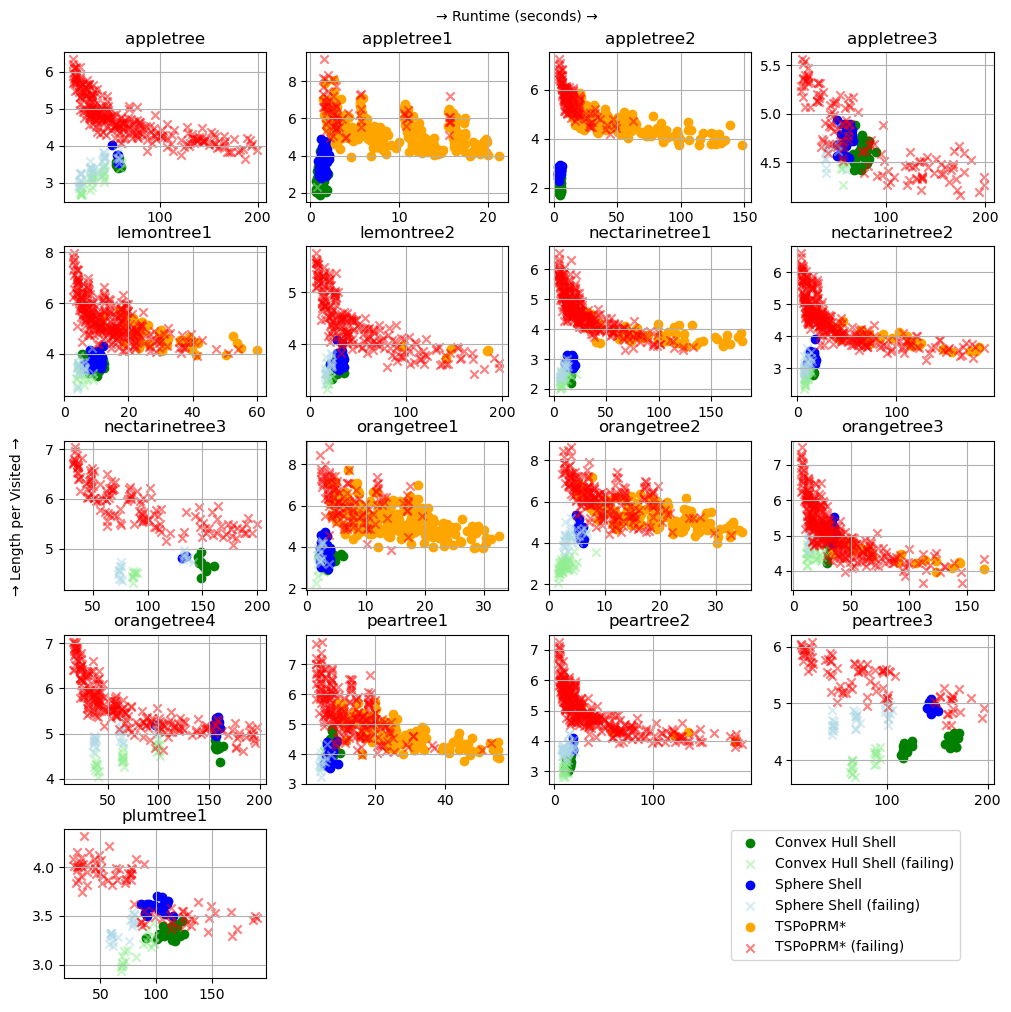

In [3]:
# Calculate the new metric
df['length_per_visited'] = df['total_path_length'] / df['n_visited']

# Create a color map for the planner names and shell types
unique_names = ['Sphere Shell', 'Convex Hull Shell', 'TSPoPRM*']
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_names)))
color_map = {
    'Sphere Shell': 'blue',
    'Convex Hull Shell': 'green',
    'TSPoPRM*': 'orange'
}

# Create a color map for low visit ratio data points
low_colors = plt.cm.autumn(np.linspace(0, 1, len(unique_names)))
low_color_map = {
    'Sphere Shell': 'lightblue',
    'Convex Hull Shell': 'lightgreen',
    'TSPoPRM*': 'red'
}

# Calculate number of scenes
num_scenes = len(df['scene'].unique())

# Calculate number of rows for subplots
nrows = (num_scenes + 3) // 4  # Add 3 to round up

# Create a grid of scatterplots
fig, axs = plt.subplots(nrows, 4, figsize=(10, 10))

# Keep track of handles and labels for the legend
handles, labels = [], []

grouped_scene = df.groupby('scene')

# Loop through each subplot and scene data
for i, (ax, (scene, scene_runs)) in enumerate(zip(axs.flatten(), grouped_scene)):
    
    # Plot data for this scene
    plot_scene_data(ax, scene_runs, color_map, low_color_map, handles, labels)
    
    # Set title and labels for this subplot
    ax.set_title(scene)

# Remove unused subplots
for j in range(i+1, nrows*4):
    fig.delaxes(axs.flatten()[j])
    
# Set common labels
fig.text(0.5, 1.0, '→ Runtime (seconds) →', ha='center', va='center')
fig.text(0.0, 0.5, '→ Length per Visited →', ha='center', va='center', orientation='vertical')

# Adjust the position of the legend
fig.legend(handles, labels, bbox_to_anchor=(0.95, 0.05), loc='lower right')

# Tight layout
plt.tight_layout()

fig.subplots_adjust(hspace=0.3,wspace=0.2)  # You can adjust the values as needed

plt.savefig('stats_length_per_visited_vs_time.pdf', dpi=300)

# Show plot
plt.show()

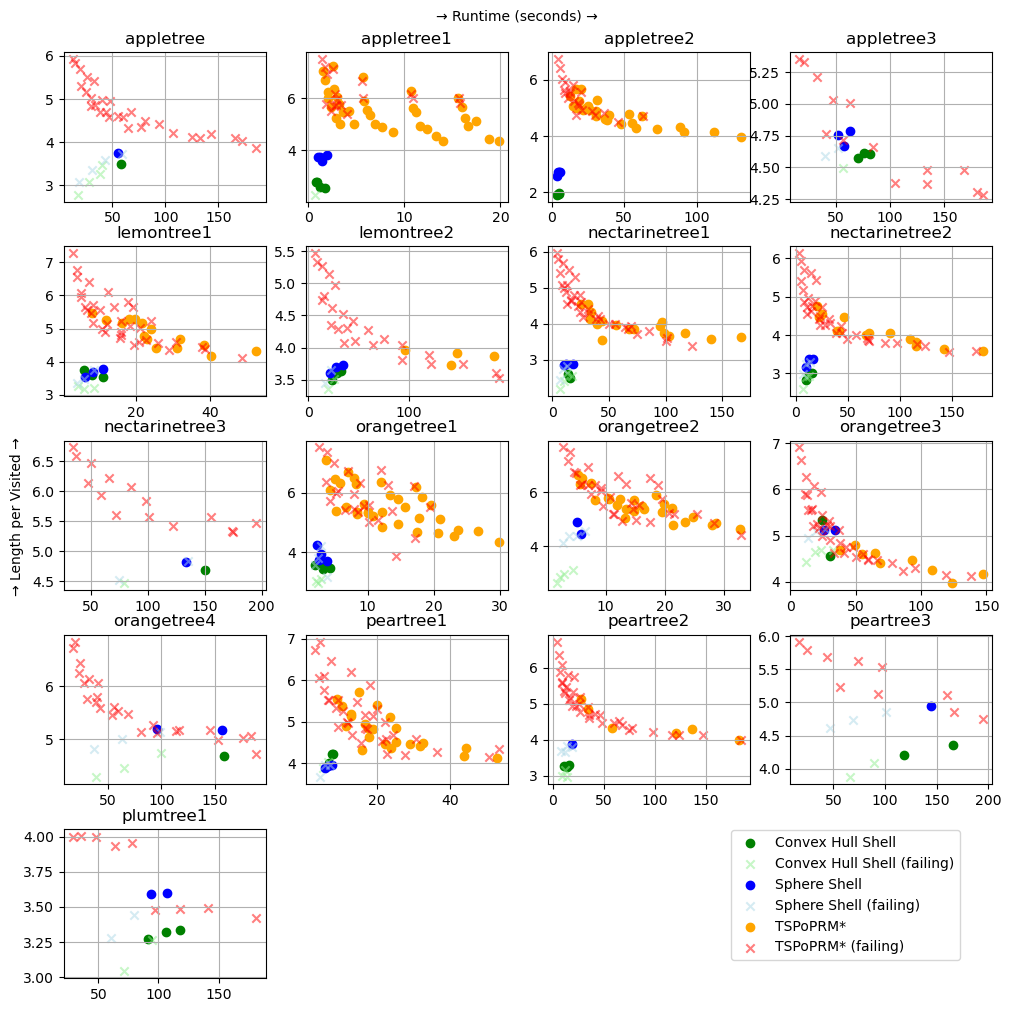

In [4]:


# Create a color map for the planner names and shell types
unique_names = ['Sphere Shell', 'Convex Hull Shell', 'TSPoPRM*']
colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_names)))
color_map = {
    'Sphere Shell': 'blue',
    'Convex Hull Shell': 'green',
    'TSPoPRM*': 'orange'
}

# Create a color map for low visit ratio data points
low_colors = plt.cm.autumn(np.linspace(0, 1, len(unique_names)))
low_color_map = {
    'Sphere Shell': 'lightblue',
    'Convex Hull Shell': 'lightgreen',
    'TSPoPRM*': 'red'
}

# Calculate number of scenes
num_scenes = len(df['scene'].unique())

# Calculate number of rows for subplots
nrows = (num_scenes + 3) // 4  # Add 3 to round up

# Create a grid of scatterplots
fig, axs = plt.subplots(nrows, 4, figsize=(10, 10))

# Keep track of handles and labels for the legend
handles, labels = [], []

grouped_scene = agg.groupby('scene')

# Loop through each subplot and scene data
for i, (ax, (scene, scene_runs)) in enumerate(zip(axs.flatten(), grouped_scene)):
    
    # Iterate through the groups of data defined by planner and shell type
    for ((planner, st), runs) in scene_runs.groupby(['name', 'shell_type'], dropna=False):
        
        # Get the user-friendly planner name
        name = get_planner_name(planner, st)
        
        if not name:
            continue
        
        # Select color based on the planner name
        color = color_map[name]
        
        # Split data based on visit_ratio
        low_ratio_data = runs[runs['low_visit_ratio']]
        high_ratio_data = runs[~runs['low_visit_ratio']]
        
        # Plot the high ratio data
        h1 = ax.scatter(high_ratio_data['time'], high_ratio_data['length_per_visited'], color=color)
        
        # Store handle and label for legend if not already stored
        if name not in labels:
            handles.append(h1)
            labels.append(name)
            
        # Plot the low ratio data if present
        low_color = low_color_map[name]
        h2 = ax.scatter(low_ratio_data['time'], low_ratio_data['length_per_visited'], color=low_color, marker='x', alpha=0.5)

        # Store handle and label for legend if not already stored
        if f'{name} (failing)' not in labels:
            handles.append(h2)
            labels.append(f'{name} (failing)')
            
        ax.grid()

    
    # Set title and labels for this subplot
    ax.set_title(scene)

# Remove unused subplots
for j in range(i+1, nrows*4):
    fig.delaxes(axs.flatten()[j])
    
# Set common labels
fig.text(0.5, 1.0, '→ Runtime (seconds) →', ha='center', va='center')
fig.text(0.0, 0.5, '→ Length per Visited →', ha='center', va='center', orientation='vertical')

# Adjust the position of the legend
fig.legend(handles, labels, bbox_to_anchor=(0.95, 0.05), loc='lower right')

# Tight layout
plt.tight_layout()

fig.subplots_adjust(hspace=0.3,wspace=0.2)  # You can adjust the values as needed

plt.savefig('stats_length_per_visited_vs_time_means.pdf', dpi=300,bbox_inches="tight")

# Show plot
plt.show()

In [11]:
# Step 1: Compute the longest time per scene with a 5% increase and merge it with the 'agg' DataFrame
time_limit_per_scene = agg[(agg['name'] == 'shell_based') & (agg['shell_type'] == 'cgal_convex_hull')].groupby('scene')['time'].max().reset_index()
time_limit_per_scene['time'] *= 1.05
merged_data = pd.merge(agg, time_limit_per_scene, on='scene', suffixes=('', '_limit'))

# Step 2: Filter the DataFrame to consider only rows where 'time' is within the time limit
filtered_data = merged_data[merged_data['time'] <= merged_data['time_limit']]

# Step 3: Group by 'scene', 'name', and 'shell_type', and find the minimum 'length_per_visited' for each group
time_parity_stats = filtered_data.groupby(['scene', 'name', 'shell_type','n_total'], dropna=False)[['length_per_visited','visit_ratio']].agg({'length_per_visited':'min','visit_ratio':'max'}).reset_index()

time_parity_stats['n_total_bin'] = pd.cut(time_parity_stats['n_total'], [0,50,100,300,600])

time_parity_stats.sort_values(['n_total_bin', 'name', 'shell_type'], inplace=True)

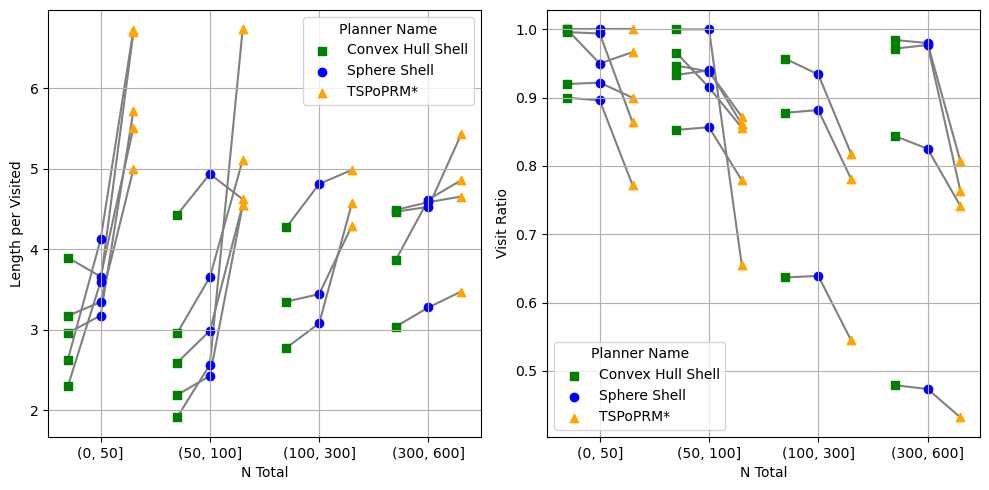

In [12]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

# Create a dictionary to map planner names to marker styles
marker_map = {
    'Sphere Shell': 'o',
    'Convex Hull Shell': 's',
    'TSPoPRM*': '^'
}

# Create a dictionary to map planner names to colors
color_map = {
    'Sphere Shell': 'blue',
    'Convex Hull Shell': 'green',
    'TSPoPRM*': 'orange'
}

# Create a dictionary to offset each planner name slightly on the x-axis
offset_map = {
    'Sphere Shell': -0.1,
    'Convex Hull Shell': 0.0,
    'TSPoPRM*': 0.1
}

offset_scale = 0.3

for name, data in time_parity_stats.groupby('scene', dropna=False):
    
    xs = np.linspace(-offset_scale,offset_scale,3) + data['n_total_bin'].cat.codes
    axs[0].plot(xs, data['length_per_visited'], color='gray',zorder=-1)
    axs[1].plot(xs, data['visit_ratio'], color='gray', zorder=-1)

# Create a scatter plot for 'length_per_visited'
for planner_i, ((name, shell),planner_data) in enumerate(time_parity_stats.groupby(['name','shell_type'], dropna=False)):
    planner_name = get_planner_name(name,shell)
    axs[0].scatter(planner_data['n_total_bin'].cat.codes + ((planner_i-1)*offset_scale), planner_data['length_per_visited'], label=planner_name, color=color_map[planner_name], marker=marker_map[planner_name])
    axs[1].scatter(planner_data['n_total_bin'].cat.codes + ((planner_i-1)*offset_scale), planner_data['visit_ratio'], label=planner_name, color=color_map[planner_name], marker=marker_map[planner_name])

axs[0].set_xlabel('N Total')
axs[0].set_ylabel('Length per Visited')
axs[0].grid(True)

axs[1].set_xlabel('N Total')
axs[1].set_ylabel('Visit Ratio')
axs[1].grid(True)

# Set the x-ticks and x-tick labels to be the bin ranges
x_ticks = range(len(time_parity_stats['n_total_bin'].unique()))
x_ticklabels = [str(interval) for interval in time_parity_stats['n_total_bin'].unique()]
axs[0].set_xticks(x_ticks, x_ticklabels, orientation=0)
axs[1].set_xticks(x_ticks, x_ticklabels, orientation=0)

# Add a legend to each subplot
for ax in axs:
    ax.legend(title='Planner Name')

fig.tight_layout()

plt.savefig('length_per_visited_and_visit_ratio_by_n_total.pdf')

plt.show()


In [7]:
# Apply the function to create a new column 'planner_name'
optimized_length_per_visited['planner_name'] = optimized_length_per_visited.apply(lambda row: get_planner_name(row['name'], row['shell_type']), axis=1)

# Set the color map
color_map = {
    'Sphere Shell': 'blue',
    'Convex Hull Shell': 'green',
    'TSPoPRM*': 'orange'
}

# Set the figure size
plt.figure(figsize=(10, 6))

# Create bins of 'n_total'

# Calculate the mean of 'length_per_visited' for each bin
grouped = optimized_length_per_visited.groupby(['n_total_bin', 'planner_name'], dropna=False)['length_per_visited'].mean().reset_index()

# Iterate over each unique 'planner_name'
for planner_name in grouped['planner_name'].unique():
    data = grouped[grouped['planner_name'] == planner_name]
    plt.plot(range(len(data)), data['length_per_visited'], label=planner_name, color=color_map[planner_name])

# Set the title and labels
plt.title('Average Length per Visited by N Total Bin')
plt.xlabel('N Total Bin')
plt.ylabel('Average Length per Visited')

# Define the x ticks and labels to be the bin ranges
x_ticks = range(len(grouped['n_total_bin'].unique()))
x_ticklabels = [str(interval) for interval in grouped['n_total_bin'].unique()]
plt.xticks(x_ticks, x_ticklabels, orientation=45)

plt.grid()

# Add a legend
plt.legend(title='Planner Name')

plt.savefig('avg_length_per_visited_by_n.pdf')

# Show the plot
plt.show()

NameError: name 'optimized_length_per_visited' is not defined

In [ ]:
# Calculate the minimum, mean and maximum of 'length_per_visited' for each bin and planner
grouped = optimized_length_per_visited.groupby(['n_total_bin', 'planner_name'], dropna=False)['length_per_visited'].agg(['min', 'mean', 'max']).reset_index()

# Set up the plot
fig, ax = plt.subplots(figsize=(10, 6))

# Iterate over each unique 'planner_name'
for planner_name in grouped['planner_name'].unique():
    data = grouped[grouped['planner_name'] == planner_name]
    x = range(len(data))
    y = data['mean']
    ymin = data['min']
    ymax = data['max']
    
    # Plot the average data as a line
    ax.plot(x, y, label=planner_name, color=color_map[planner_name])
    
    # Fill the area between the minimum and maximum with a lighter shade of the same color
    ax.fill_between(x, ymin, ymax, color=color_map[planner_name], alpha=0.3)

# Set the title and labels
ax.set_title('Average Length per Visited by N Total Bin')
ax.set_xlabel('N Total Bin')
ax.set_ylabel('Average Length per Visited')

# Define the x ticks and labels to be the bin ranges
x_ticks = range(len(grouped['n_total_bin'].unique()))
x_ticklabels = [str(interval) for interval in grouped['n_total_bin'].unique()]
ax.set_xticks(x_ticks)
ax.set_xticklabels(x_ticklabels, orientation=45)

ax.grid()

# Add a legend
ax.legend(title='Planner Name')

# Save and display the plot
plt.savefig('avg_length_per_visited_by_n_with_shade.pdf')
plt.show()


In [ ]:
# Filter data for planner names containing 'tsp_over_prm*'
tsp_over_prm_data = agg[agg['name'].str.contains('tsp_over_prm')]

# Calculate number of scenes for tsp_over_prm data
num_scenes_tsp = len(tsp_over_prm_data['scene'].unique())

# Calculate number of rows for subplots for tsp_over_prm data
nrows_tsp = (num_scenes_tsp + 3) // 4  # Add 3 to round up

# Create a grid of scatterplots for tsp_over_prm data
fig_tsp, axs_tsp = plt.subplots(nrows_tsp, 4, figsize=(10, 10))

grouped_scene_tsp = tsp_over_prm_data.groupby('scene')

# Loop through each subplot and scene data for tsp_over_prm data
for i, (ax, (scene, scene_runs)) in enumerate(zip(axs_tsp.flatten(), grouped_scene_tsp)):
    
    # Create twin axes for n_visited
    ax2 = ax.twinx()
    
    # Group by samples_per_goal
    for samples_per_goal, group in scene_runs.groupby('samples_per_goal'):
        
        # Sort by prm_build_time for a continuous line plot
        group = group.sort_values('prm_build_time')
        
        # Plot average time against prm_build_time in green (on the first axis)
        ax.plot(group['prm_build_time'], group['time'], color='green', label=f'{samples_per_goal} samples_per_goal')
        
        # Plot n_visited in red (on the twin axis)
        ax2.plot(group['prm_build_time'], group['n_visited'], color='red', alpha=0.5, label=f'{samples_per_goal} samples_per_goal (n_visited)')
    
    # Set title and labels for this subplot
    ax.set_title(scene)
    ax.set_xlabel('prm_build_time')
    ax.set_ylabel('Average Time', color='green')
    ax2.set_ylabel('n_visited', color='red')
    ax.grid()

    # Add legends
    lines, labels = ax.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()

# Remove unused subplots
for j in range(i+1, nrows_tsp*4):
    fig_tsp.delaxes(axs_tsp.flatten()[j])

# Tight layout
plt.tight_layout()

fig_tsp.subplots_adjust(hspace=0.3, wspace=0.2)  # You can adjust the values as needed

plt.savefig('tsp_over_prm_stats_with_n_visited.pdf', dpi=300, bbox_inches="tight")

# Show plot
plt.show()

